In [116]:
import pandas as pd
import numpy as np
import cpi
from ipython_genutils.text import columnize
from torch.utils.hipify.hipify_python import value

In [117]:
#Load movie databases
movie_df = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
sequel_collections_with_wiki_id = pd.read_csv('data/collections/sequels_and_original_with_wiki_id.csv')
sequels_with_wiki_id = pd.read_csv('data/movie_with_keyword_sequel_with_wiki_id.csv')

#re
movie_df.rename(columns={0: 'Wikipedia movie ID', 1: "Freebase movie ID", 2: "Movie name",  3: "Movie release date", 4: "Movie box office revenue", 5: "Movie runtime", 6: "Movie languages", 7: "Movie countries", 8: "Movie genres"}, inplace=True)

In [118]:
movie_df_sequel_original = movie_df.join(sequel_collections_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')
movie_df_sequel_only = movie_df.join(sequels_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')

In [119]:
movie_df_sequel_only["release year wiki"] = movie_df_sequel_only["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_only["release year tmdb"] = movie_df_sequel_only["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)

movie_df_sequel_only.drop(movie_df_sequel_only[movie_df_sequel_only["release year wiki"] != movie_df_sequel_only["release year tmdb"]].index, inplace=True)
movie_df_sequel_only["release year"] = movie_df_sequel_only["release year wiki"].astype(float)
movie_df_sequel_only.drop("release year tmdb", axis=1, inplace=True)
movie_df_sequel_only.drop("release year wiki", axis=1, inplace=True)


In [120]:
movie_df_sequel_original["release year wiki"] = movie_df_sequel_original["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_original["release year tmdb"] = movie_df_sequel_original["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)

movie_df_sequel_original.drop(movie_df_sequel_original[movie_df_sequel_original["release year wiki"] != movie_df_sequel_original["release year tmdb"]].index, inplace=True)
movie_df_sequel_original["release year"] = movie_df_sequel_original["release year wiki"].astype(float)
movie_df_sequel_original.drop("release year tmdb", axis=1, inplace=True)
movie_df_sequel_original.drop("release year wiki", axis=1, inplace=True)

### 3.1 How many sequels are there compared to movies 

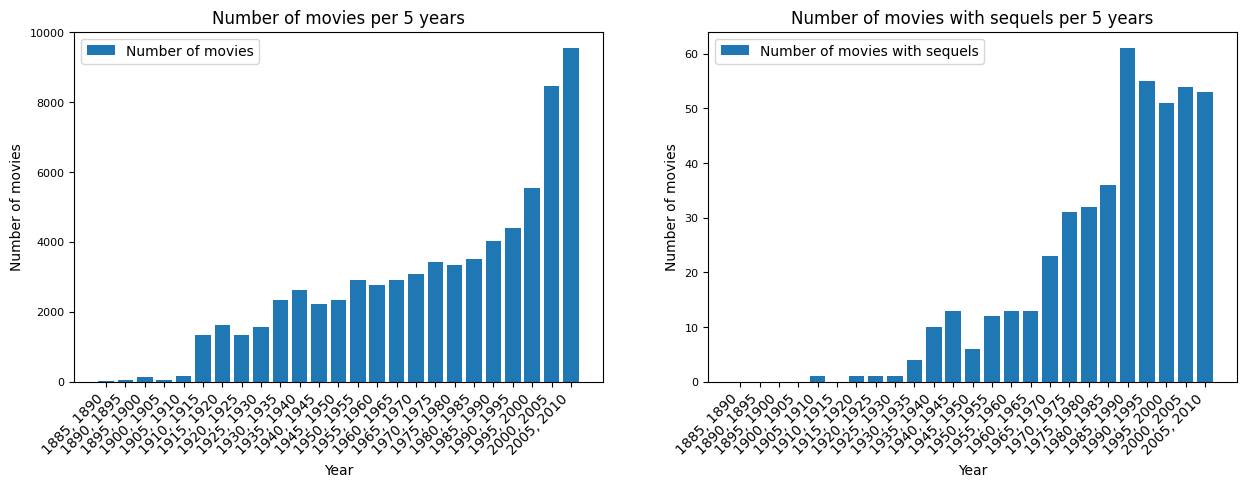

In [121]:
movie_df["release year"] = movie_df["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df["release year"] = movie_df["release year"].astype(float)

movie_df = movie_df[movie_df["release year"] >= 1880]
movie_df = movie_df[movie_df["release year"] < 2010]

movie_df_sequel_only["release year"] = (movie_df_sequel_only["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan))
movie_df_sequel_only["release year"] = movie_df_sequel_only["release year"].astype(float)

movie_df_sequel_only = movie_df_sequel_only[movie_df_sequel_only["release year"] >= 1880]
movie_df_sequel_only = movie_df_sequel_only[movie_df_sequel_only["release year"] < 2010]

movies_per_years = movie_df.groupby(pd.cut(movie_df["release year"], np.arange(1885, 2011, 5))).count()
movies_sequel_per_year = movie_df_sequel_only.groupby(pd.cut(movie_df_sequel_only["release year"], np.arange(1885, 2011, 5))).count()

years = movies_per_years.index.astype(str)
years = [x[1:][:-1] for x in years]

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(221)
ax1.bar(years, movies_per_years["Wikipedia movie ID"], label="Number of movies")
ax1.legend()
ax1.title.set_text("Number of movies per 5 years")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of movies")
plt.xticks(rotation=45, ha='right')

ax2 = fig.add_subplot(222)
ax2.bar(years, movies_sequel_per_year["Wikipedia movie ID"], label="Number of movies with sequels")
ax2.legend()
ax2.title.set_text("Number of movies with sequels per 5 years")
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of movies")
plt.xticks(rotation=45, ha='right')

plt.show()

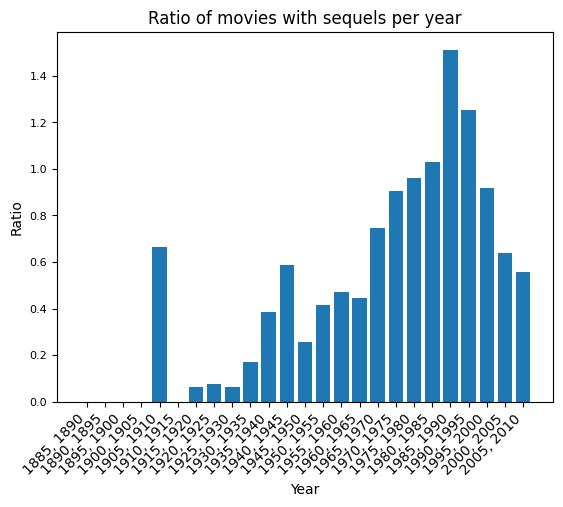

In [122]:
    #remove the years with less than 50 movies
movies_per_years_removed = movies_per_years[movies_per_years["Wikipedia movie ID"] > 50]

movie_df_ratio = movies_sequel_per_year / movies_per_years_removed * 100
movie_df_ratio = movie_df_ratio.fillna(0)

plt.bar(years, movie_df_ratio["Wikipedia movie ID"])
plt.title("Ratio of movies with sequels per year")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.xticks(rotation=45, ha='right')
plt.show()

In [123]:
def inflate(revenue, year):
    if np.isnan(revenue) or np.isnan(year) or year < 1900:
        return np.nan
    if len(str(year)) != 4:
        year = int(str(year)[:4])
    return cpi.inflate(revenue, year)

movie_df["Movie box office revenue inflation adj"] = movie_df.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)


In [124]:
movie_df_sequel_only["Movie box office revenue inflation adj"] = movie_df_sequel_only.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)
movie_df_sequel_original["Movie box office revenue inflation adj"] = movie_df_sequel_original.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)

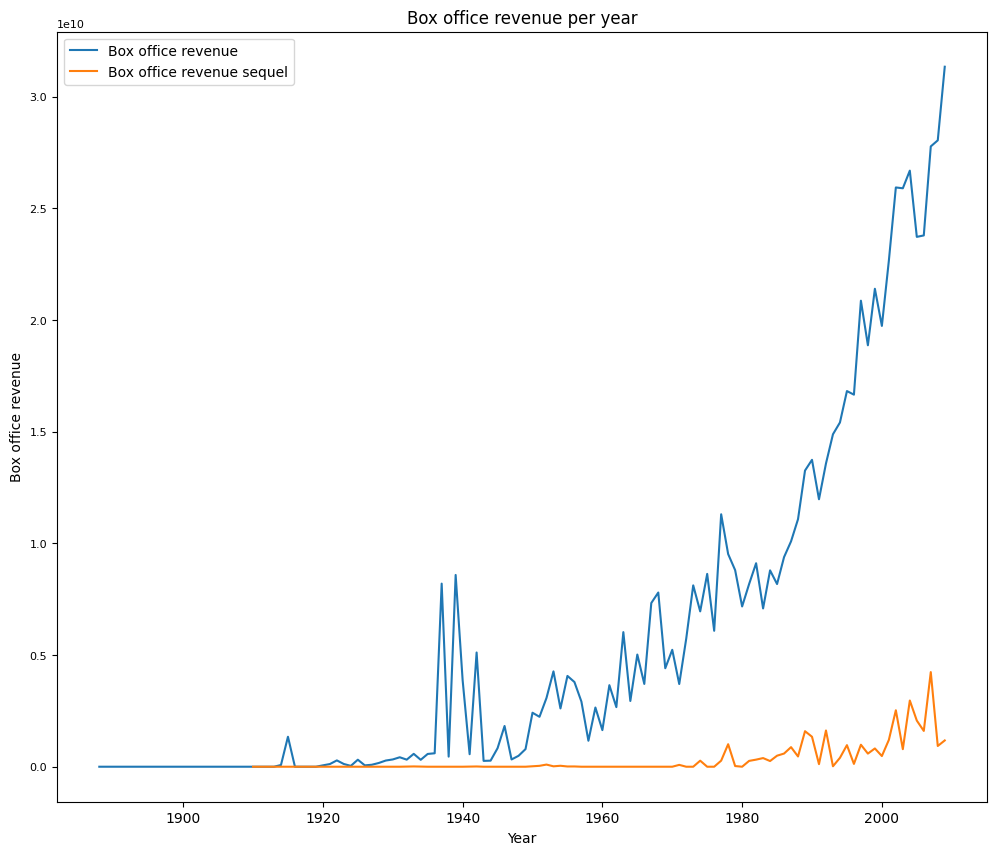

In [125]:
box_office_per_year = movie_df.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')
box_office_sequel_per_year = movie_df_sequel_only.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')

box_office_per_year = box_office_per_year.fillna(0)
box_office_sequel_per_year = box_office_sequel_per_year.fillna(0)

"""
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot()
ax1.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax1.legend()
ax1.title.set_text("Box office revenue per year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Box office revenue")

ax2 = fig.add_subplot()
ax2.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")
ax2.legend()
ax2.title.set_text("Box office revenue sequel per year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Box office revenue")
"""

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")

ax.legend()
ax.set_title("Box office revenue per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")

plt.show()

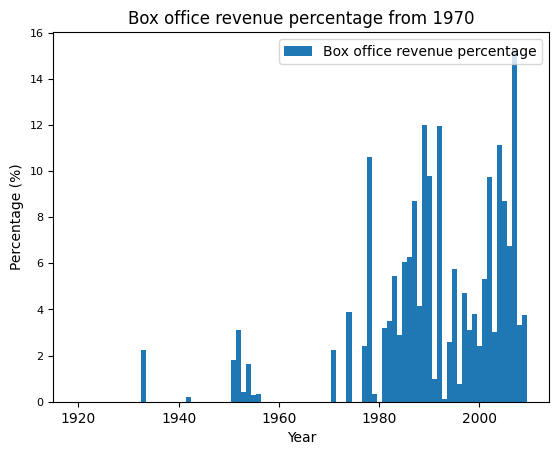

In [126]:
box_office_percentage = box_office_sequel_per_year / box_office_per_year * 100

box_office_percentage_plot, ax = plt.subplots()
ax.bar(box_office_percentage.index, box_office_percentage, label="Box office revenue percentage", width=1)
ax.legend()
ax.title.set_text("Box office revenue percentage from 1970")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage (%)")

plt.show()

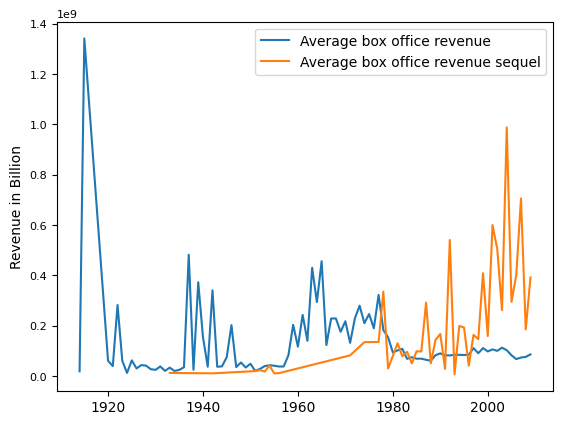

In [127]:
average_box_office = movie_df.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office = average_box_office.fillna(0)
average_box_office_sequel = movie_df_sequel_only.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office_sequel = average_box_office_sequel.fillna(0)

average_box_office_plot, ax = plt.subplots()
ax.plot(average_box_office.index, average_box_office, label="Average box office revenue")
ax.plot(average_box_office_sequel.index, average_box_office_sequel, label="Average box office revenue sequel")
ax.legend()
ax.set_ylabel("Revenue in Billion")
plt.show()

#### Box office revenue compared to the first movie

In [128]:
box_office_first_movie = movie_df_sequel_original.sort_values("release_date").groupby("collection").first()["Movie box office revenue inflation adj"]
box_office_remainder = movie_df_sequel_original.groupby("collection")["Movie box office revenue inflation adj"].agg('sum') - box_office_first_movie

box_office_remainder_avg = box_office_remainder / (movie_df_sequel_original.groupby("collection").count()["Movie name"] - 1)

In [129]:
first_vs_rest = pd.DataFrame()
first_vs_rest["first"] = box_office_first_movie
first_vs_rest["rest"] = box_office_remainder
first_vs_rest["rest_avg"] = box_office_remainder_avg

first_vs_rest = first_vs_rest[first_vs_rest["rest"] > 0]
first_vs_rest = first_vs_rest.sort_values("first", ascending=True)

In [130]:
first_vs_rest['index'] = range(0, len(first_vs_rest))

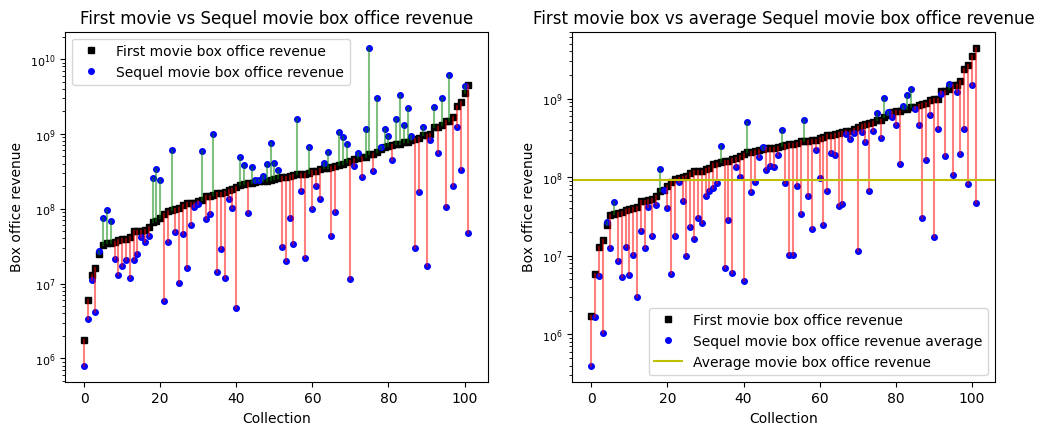

In [131]:
fig = plt.figure(figsize=(12, 10))

average_movie_revenue = movie_df.dropna(subset = ['Movie box office revenue inflation adj'])["Movie box office revenue inflation adj"].agg('mean')

ax1 = fig.add_subplot(221)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest"]
ax1.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax1.plot(x, y2, 'bo', markersize = 4, label="Sequel movie box office revenue")

ax1.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)
ax1.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)

ax1.legend()
ax1.title.set_text("First movie vs Sequel movie box office revenue")
ax1.set_xlabel("Collection")
ax1.set_ylabel("Box office revenue")
ax1.set_yscale("log")


ax2 = fig.add_subplot(222)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest_avg"]
ax2.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax2.plot(x, y2, 'bo', markersize = 4, label="Sequel movie box office revenue average")

ax2.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)
ax2.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)
ax2.axhline(y=average_movie_revenue, color='y', linestyle='-', label="Average movie box office revenue")

ax2.legend()
ax2.title.set_text("First movie box vs average Sequel movie box office revenue")
ax2.set_xlabel("Collection")
ax2.set_ylabel("Box office revenue")
ax2.set_yscale("log")

plt.show()


#### Number of movies in a collection

In [138]:
collection_size = movie_df_sequel_original.groupby("collection").count()["Movie name"]

box_office_revenue = movie_df_sequel_original.groupby("collection")["Movie box office revenue inflation adj"].agg('sum')

sequels_extended = pd.read_csv("data/sequels/sequels_extended_1880_2010.csv")
movie_df_sequel_original = pd.merge(movie_df_sequel_original, sequels_extended[["id", "budget"]], on="id", how="inner") if "budget" not in movie_df_sequel_original.columns else movie_df_sequel_original
budget_df = movie_df_sequel_original.groupby("collection")["budget"].agg('sum')

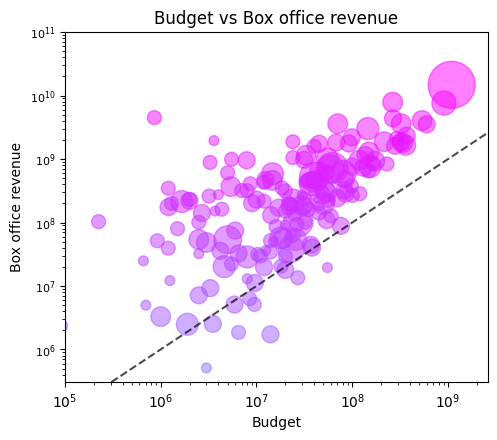

In [157]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(221)

ax.scatter(budget_df, box_office_revenue, s = collection_size * 50, alpha=0.5, c = np.log(box_office_revenue + 1), cmap="cool")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Budget")
ax.set_ylabel("Box office revenue")

ax.set_xlim(xmin = 1e5)
ax.set_ylim(ymax = 1e11)

plt.axline((0,0), xy2=(1e11, 1e11), linestyle='--',color='black', alpha=0.7, label = "Profit Line")
ax.title.set_text("Budget vs Box office revenue")
plt.show()

Other line of enquiry:

Highest grossing series

By genre

Find studios that do a lot of sequels

Is there a correlation between the box office revenue of the first movie and the sequels

Add more box office revenue data and get movie budget data

#### Time between sequels

In [152]:
first_movie = movie_df_sequel_original.sort_values("release_date").groupby("collection").first()
sequel_movies = movie_df_sequel_original.sort_values("release_date").groupby("collection").tail(-1)

In [153]:
collection_release_date = pd.DataFrame()
collection_release_date["collection"] = first_movie.index
collection_release_date["movie date"] = first_movie["release_date"].values
collection_release_date["movie title"] = first_movie["Movie name"].values
collection_release_date["Movie box office revenue inflation adj"] = first_movie["Movie box office revenue inflation adj"].values
collection_release_date = collection_release_date.sort_values("Movie box office revenue inflation adj", ascending=False).head(50)

sequel_temp = pd.DataFrame()
sequel_movies_top = sequel_movies[sequel_movies["collection"].isin(collection_release_date["collection"].values)]
sequel_temp["collection"] = sequel_movies_top["collection"].values
sequel_temp["movie date"] = sequel_movies_top["release_date"].values
sequel_temp["movie title"] = sequel_movies_top["Movie name"].values
sequel_temp["Movie box office revenue inflation adj"] = sequel_movies_top["Movie box office revenue inflation adj"].values

collection_release_date = pd.concat([collection_release_date, sequel_temp])
collection_release_date["movie date"] = pd.to_datetime(collection_release_date["movie date"])
collection_release_date["collection"] = collection_release_date["collection"].apply(lambda x: x.replace(" Collection", ""))

time_from_last = []
prequel_name = []
prequel_date = []
collection_release_date = collection_release_date.sort_values(["collection", "movie date"])
previous= 0
collection_previous = ""
movie_previous = ""
for movie in collection_release_date.iterrows():
    collection = movie[1]["collection"]
    date = movie[1]["movie date"]
    if(collection != collection_previous):
        prequel_name.append(None)
        time_from_last.append(0)
        prequel_date.append(None)
    else :
        time_from_last.append((date - previous).days)
        prequel_name.append(movie_previous)
        prequel_date.append(previous)
    previous = date
    collection_previous = collection 
    movie_previous = movie[1]["movie title"]
    
collection_release_date["time from last"] = time_from_last
collection_release_date["prequel name"] = prequel_name
collection_release_date["prequel date"] = prequel_date
collection_release_date = collection_release_date[collection_release_date.groupby("collection").collection.transform(len) > 1]


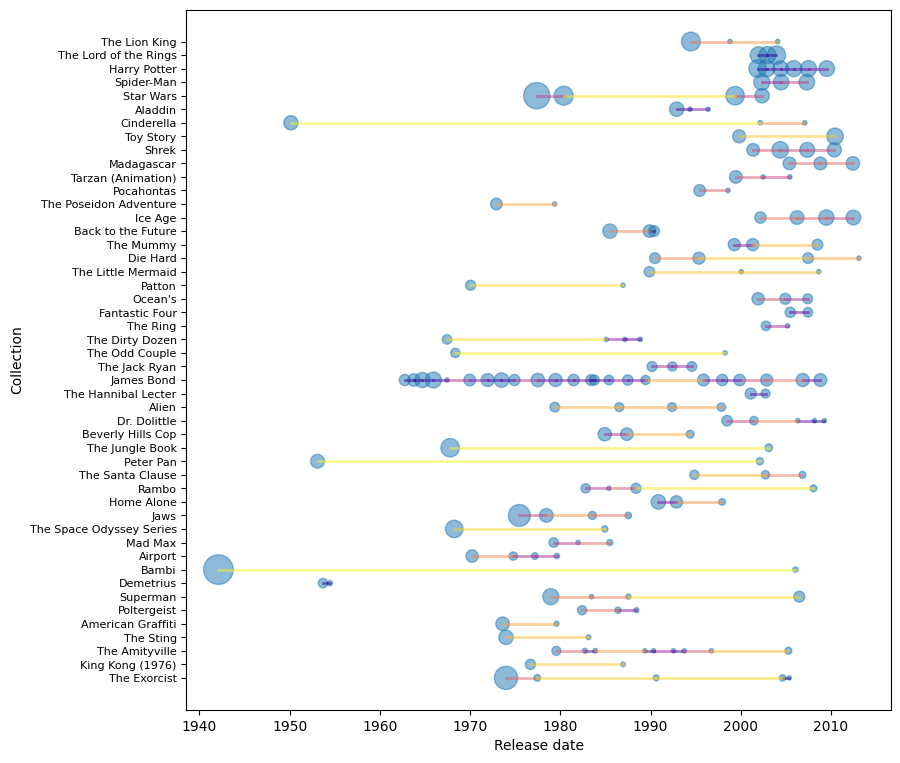

In [155]:
from matplotlib import colormaps
from matplotlib import cm

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(221)

collection_release_date = collection_release_date.sort_values("Movie box office revenue inflation adj", ascending=True)
x = collection_release_date["movie date"]
y = collection_release_date["collection"]


ax.scatter(x, y, s = 10 + collection_release_date["Movie box office revenue inflation adj"].fillna(0)/10000000, alpha=0.5)

x_line, y_line = np.array([]), np.array([])

max_time = collection_release_date["time from last"].max()

time = collection_release_date["time from last"].values
time =  time[time != 0]

color = cm.plasma(np.linspace(0, 1, num=time.shape[0]))

collection_release_date = collection_release_date.sort_values("time from last")
j=0
for i, movie in collection_release_date.iterrows():
    prev_year = movie["prequel date"]
    curr_year = movie["movie date"]
    collection = movie["collection"]
    prev_movie = movie["prequel name"]
    if prev_movie is not None:
        x_line = np.append(x_line, [prev_year, curr_year])
        y_line = np.append(y_line, [collection, collection])
        ax.plot([prev_year, curr_year], [collection, collection], alpha=0.5, c = color[j], linewidth=2)
        j += 1
    
ax.set_xlabel("Release date")
ax.set_ylabel("Collection")
ax.title.set_text("Time between sequels")
plt.rc('ytick', labelsize=8)
plt.show()

#### Time Histogram

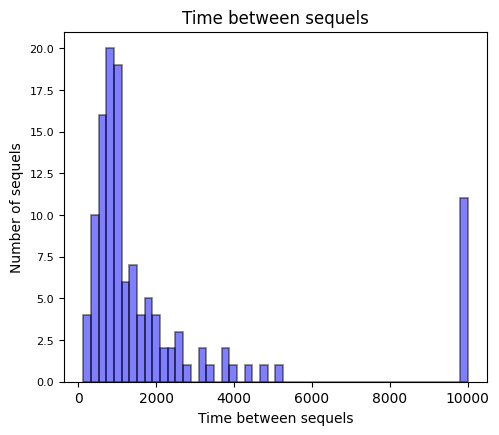

In [166]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(221)

time = collection_release_date["time from last"].apply(lambda x: x if x < 6000 else 10000).values
time =  time[time != 0]

ax.hist(time, bins=50, alpha=0.5, color='b', edgecolor='black', linewidth=1.2)
ax.set_xlabel("Time between sequels")
ax.set_ylabel("Number of sequels")
ax.title.set_text("Time between sequels")
plt.show()